targets.shape=(36, 2)


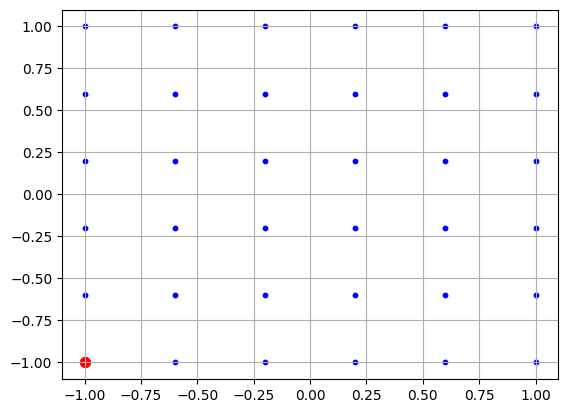

In [1]:
from matplotlib import pyplot as plt
from pprint import pp
import numpy as np

# Chose number of robots
k = int(6)
# Chose recharging proportionality constant
q_k = 0.1  # This means that each robot will need to charge for 10 minutes for every 100 minutes travelled
# Chose the number of targets in an axis
n = int(6)

# nodes = targets + depots
# Create a uniform (n*n, 2) numpy target grid for MAXIMUM SPEED
targets = np.mgrid[-1:1:n * 1j, -1.:1:n * 1j]
targets = targets.reshape(targets.shape + (1,))
targets = np.concatenate((targets[0], targets[1]), axis=2)
targets = targets.reshape((n*n, 2))
target_indices = range(len(targets))
print(f"{targets.shape=}")

# Specify depots
# One depot node in the corner
depots = np.array([
    [-1., -1.],
])
## Four depot nodes (one in each corner)
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.1,
# ])
# depots = np.array([
#     [-1., -1.],
#     [-1., 1.],
#     [1., -1.],
#     [1., 1.],
# ])
# print(f"{depots=}")
depots = np.concatenate((depots, depots))
depot_indices = range(len(targets), len(targets)+len(depots))

nodes = np.concatenate((targets, depots))
# print(f"{nodes.shape=}")
node_indices = range(len(targets)+len(depots))

# print(f"{list(target_indices)=}\n{list(depot_indices)=}\n{list(node_indices)=}")

# Chose starting depot node
# Make all robots start from same depot
B_k = np.array([depot_indices[0]] * k)
# Make depots start from multiple depots
# B_k = depot_indices[:k]
# print(f"{B_k=}")

# Graphical sanity check
plt.figure()
plt.scatter(targets[:,0], targets[:,1], c='blue', s=10)
plt.scatter(depots[:,0], depots[:,1], c='red', s=50)
plt.grid()
plt.show()

In [2]:
import itertools

# Calculate c_{i,j} (c[i,j] is the cost (including recharging, q_k) from nodes i to j)
cost = np.zeros((len(node_indices),len(node_indices)))
for i, j in itertools.product(node_indices, node_indices):
    cost[i,j] = np.sqrt((nodes[i,0]-nodes[j,0]) ** 2 + (nodes[i,1]-nodes[j,1]) ** 2)
    # print(f"({i},{j}):({nodes[i,0]},{nodes[i,1]},{nodes[j,0]},{nodes[j,1]}): {cost[i,j]}")
print(f"{cost.shape=}")


cost.shape=(38, 38)


In [3]:
import gurobipy as gp
from gurobipy import GRB

m = gp.Model()

# A. Integer Constraints (4), (5)
# Note: All edges are now binary
x = m.addMVar((k,len(node_indices),len(node_indices)), name='x', vtype=GRB.BINARY)
# for ki in range(k):
#     for i in target_indices:
#         for j in target_indices:
#             if i == j: continue
#             _ = m.addConstr(x[ki,i,j] <= 1)
#         for j in depot_indices:
#             _ = m.addConstr(x[ki,i,j] <= 1)
#             _ = m.addConstr(x[ki,j,i] <= 1)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2419685
Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com


In [4]:
# B. Degree Constraints (6), (7), (8), (9), (10)
# (6) and (7) Only one robot arrives to and leaves from a target (B_k is a depot, so we don't need to remove it from targets)
_ = m.addConstrs(x[:,i,:].sum() == 1 for i in target_indices)
_ = m.addConstrs(x[:,:,i].sum() == 1 for i in target_indices)

for ki in range(k):
    # (8) and (9) Begin and end at same position B_k
    # _ = m.addConstr(x[ki,B_k[ki,0],B_k[ki,1],:,:].sum() >= 1)
    _ = m.addConstr(x[ki,B_k[ki],:].sum() <= 1)
    # _ = m.addConstr(x[ki,:,:,B_k[ki,0],B_k[ki,1]].sum() >= 1)
    _ = m.addConstr(x[ki,:,B_k[ki]].sum() <= 1)
    
    # (10) Every robot that visits a target leaves the target
    _ = m.addConstrs((x[ki,:,i]-x[ki,i,:]).sum() == 0 for i in node_indices)

    # Additional constraint: no loopholes!
    _ = m.addConstrs(x[ki, i, i] == 0 for i in node_indices)

In [5]:
# C. Capacity and Flow Constraints (11), (12), (13), (14)
p = m.addMVar((k,len(node_indices),len(node_indices)), name='p', vtype=GRB.INTEGER, lb=0, ub=len(target_indices))

for ki in range(k):
    # (11) and (12) flow constraints
    right_side = 0
    for i, j in itertools.product(target_indices, node_indices):
        right_side += x[ki,i,j]
    _ = m.addConstr((p[ki,B_k[ki],:] - p[ki,:,B_k[ki]]).sum() == right_side)
    
    for i in target_indices:
        _ = m.addConstr((p[ki,:,i] - p[ki,i,:]).sum() == x[ki,i,:].sum())

    # (13) Make sure target capacity doesn't change when passing through a depot
    # Note: Disable for now because we only have one depot which is the starting point
    for i in depot_indices:
        if i == B_k[ki]: continue  # Why? See: https://github.com/NESTLab/mrpcp#linear-constraints
        left_side = 0
        for j in node_indices:
            if i == j: continue
            left_side += p[ki,j,i] - p[ki,i,j]
        _ = m.addConstr(left_side == 0)

    # (14) Ensure that target capacity for each robot doesn't exceed |T|
    _ = m.addConstrs(p[ki,i,j] <= len(target_indices) * x[ki,i,j] for i in node_indices for j in node_indices)

In [6]:
# # D. Fuel Constraints (15), (16), (17), (18), (19), (20)
max_fuel_cost_to_node = np.sqrt(8)  # √8 is the max possible distance between our nodes (-1, -1) and (1, 1)
L = max_fuel_cost_to_node * 2.  # Fuel capacity (1 unit of fuel = 1 unit of distance)
M = L + max_fuel_cost_to_node
r = m.addMVar((len(node_indices)), name='r', vtype=GRB.CONTINUOUS, lb=0, ub=L) # (20)

for ki in range(k):
    # (15) and (16)
    for i, j in itertools.product(target_indices, target_indices):
        left_side = r[j] - r[i] + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side <=  right_side)
        _ = m.addConstr(left_side >= -right_side)

    # (17) and (18)
    for i, j in itertools.product(depot_indices, target_indices):
        left_side = r[j] - L + cost[i,j]
        right_side = M * (1 - x[ki,i,j])
        _ = m.addConstr(left_side >= -right_side)
        _ = m.addConstr(left_side <=  right_side)

        # (19)
        _ = m.addConstr(r[j] - cost[j,i] >= -M * (1 - x[ki,j,i]))

In [7]:
# Set objective function (3)
p_max = m.addVar(vtype=GRB.CONTINUOUS, name="p_max")
_ = m.addConstrs((cost * x[ki]).sum() <= p_max for ki in range(k))
m.setObjective(p_max)

In [8]:
import datetime


def visualize_paths_brute_force(edges):
    # Only plot the paths for the robots that were assigned a path
    active_robots = []
    for ki in range(k):
        if (cost * edges[ki]).sum() > 0.01:
            active_robots.append(ki)

    subplot_per_hor_axis = int(np.ceil(np.sqrt(len(active_robots))))
    subplot_per_vert_axis = int(np.ceil(len(active_robots) / subplot_per_hor_axis))
    fig, axs = plt.subplots(subplot_per_hor_axis, subplot_per_vert_axis, figsize=(subplot_per_hor_axis * 4, subplot_per_vert_axis * 4))
    fig.tight_layout()
    fig.subplots_adjust(bottom=0.1, top=0.9, right=0.9, left=0.1, wspace=0.3, hspace=0.3)

    hor_i = 0
    vert_i = 0
    for robot_i, ki in enumerate(active_robots):
        # print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
            ax = axs
        elif subplot_per_vert_axis == 1:
            ax = axs[hor_i]
        else:
            ax = axs[hor_i][vert_i]
        ax.set_title(f"Robot #{robot_i+1} (cost={(cost * edges[ki]).sum():.3f})")
        ax.scatter(targets[:,0], targets[:,1], c='blue', s=10)
        ax.scatter(depots[:,0], depots[:,1], c='red', s=50)
        ax.scatter(nodes[B_k[ki], 0], nodes[B_k[ki], 1], c='red', s=100)

        for i, j in itertools.product(node_indices, node_indices):
            if edges[ki,i,j] > 0.5:  # In case there is any floating math errors
                # print(f"Connection from {[i1,j1]} to {[i2,j2]}")
                ax.scatter(nodes[i, 0], nodes[i, 1], c="purple", s=8)
                ax.scatter(nodes[j, 0], nodes[j, 1], c="purple", s=8)
                ax.plot([nodes[i, 0], nodes[j, 0]], [nodes[i, 1], nodes[j, 1]], color="purple", linewidth=1)
        
        vert_i += 1
        if vert_i >= subplot_per_vert_axis:
            vert_i = 0
            hor_i += 1
        ax.grid()
    
    for h in range(subplot_per_hor_axis):
        for v in range(subplot_per_vert_axis):
            if subplot_per_hor_axis == 1 and subplot_per_vert_axis == 1:
                ax = axs
            elif subplot_per_vert_axis == 1:
                ax = axs[h]
            else:
                ax = axs[h][v]
            ax.set_box_aspect(1)
    
    fig.suptitle(f"Paths for all robots (# of active/available robots={len(active_robots)}/{k}, sum of costs={(cost * edges).sum():.3f})")
    fig.savefig(f"../../data/2015_mrpcp_k={k}_n={n}_{datetime.datetime.now().strftime('%Y-%m-%d-%H:%M:%S')}.png") 
    plt.show()

In [9]:
def get_next_nodes(edges, node):
    next_nodes = []
    for i1, j1 in itertools.product(range(n), range(n)):
        if edges[node[0],node[1],i1, j1]:
            next_nodes.append((i1,j1))
    return next_nodes

def visualize_paths_faster(edges):
    for ki in range(k):
        print(f"Robot #{ki}\n-------")
        # print(f"Staring position: {B_k[ki]} -> {[nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1]]}")
        fig = plt.figure()
        fig.suptitle(f"Path for Robot #{ki}")
        plt.scatter(nodes[:, :, 0], nodes[:, :, 1], c='blue', s=10)
        plt.scatter(nodes[depot_indices[:, 0], depot_indices[:, 1], 0], nodes[depot_indices[:, 0], depot_indices[:, 1], 1], c='red', s=50)
        plt.scatter(nodes[B_k[ki, 0], B_k[ki, 1], 0], nodes[B_k[ki, 0], B_k[ki, 1], 1], c='red', s=100)

        search_ongoing = True
        found = set()
        visited = set()
        # path_lookup = {}
        prev_node = (B_k[ki][0], B_k[ki][1])
        while search_ongoing:
            if (depot_indices == prev_node).all(1).any():
                print(f" -> D{prev_node}/({nodes[prev_node[0], prev_node[1], 0]:.2f},{nodes[prev_node[0], prev_node[1], 1]:.2f})")
            else:
                print(f" -> T{prev_node}/({nodes[prev_node[0], prev_node[1], 0]:.2f},{nodes[prev_node[0], prev_node[1], 1]:.2f})")

            neighbor_nodes = get_next_nodes(edges[ki], prev_node)
            print(f"\t{neighbor_nodes=}")

            for neighbor_node in neighbor_nodes:
                if not (depot_indices == neighbor_node).all(1).any() and neighbor_node not in found:
                    found.add(neighbor_node)

            found_next_node = False
            for neighbor_node in neighbor_nodes:
                if neighbor_node not in visited:
                    plt.scatter(nodes[prev_node[0], prev_node[1], 0], nodes[prev_node[0], prev_node[1], 1], c="purple", s=8)
                    plt.plot([nodes[prev_node[0], prev_node[1], 0], nodes[neighbor_node[0], neighbor_node[1], 0]], [nodes[prev_node[0], prev_node[1], 1], nodes[neighbor_node[0], neighbor_node[1], 1]], color="purple", linewidth=1)

                    if not (depot_indices == neighbor_node).all(1).any():
                        visited.add(neighbor_node)
                    prev_node = neighbor_node
                    found_next_node = True
                    break

            if found_next_node:
                search_ongoing = True
            elif not found_next_node and len(found) != len(visited):
                search_ongoing = True
                # print(f"{(found - visited)=}")
                print("Visualizing another loop...")
                prev_node = (found - visited).pop()
            else:
                search_ongoing = False

            # print(f"{found_next_node=} , {len(found)=} {len(visited)=}")

        plt.grid()
        plt.show()

In [10]:
class MILPSolver:
    min_cost_edges = None
    min_cost = np.inf
    def __init__(self, model):
        self.model = model
                
    @staticmethod
    def cb(what, where):
        if where == GRB.Callback.MIPSOL and what.cbGet(GRB.Callback.MIPSOL_OBJ) < MILPSolver.min_cost:
            MILPSolver.min_cost = what.cbGet(GRB.Callback.MIPSOL_OBJ)
            print(f"Found a new solution with lower cost({MILPSolver.min_cost:.3f})!")
            
            # If this solution's maximum costing tour ~= the cost of tour that only travels between depot and the furthest node,
            # then, this is guaranteed to be optimal.
            if (MILPSolver.min_cost - max_fuel_cost_to_node * 2) < 0.01:
                print("!This is guaranteed to be the optimal solution!")
                what.terminate()
            
            MILPSolver.min_cost_edges = what.cbGetSolution(what._x)
            visualize_paths_brute_force(MILPSolver.min_cost_edges)

    def solve(self):
        self.model.optimize(MILPSolver.cb)


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[arm])

CPU model: Apple M3 Max
Thread count: 14 physical cores, 14 logical processors, using up to 14 threads

Academic license 2419685 - for non-commercial use only - registered to lu___@icloud.com
Optimize a model with 26286 rows, 17367 columns and 141378 nonzeros
Model fingerprint: 0xef10a2f5
Variable types: 39 continuous, 17328 integer (8664 binary)
Coefficient statistics:
  Matrix range     [4e-01, 4e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 2078 rows and 458 columns
Presolve time: 0.13s
Presolved: 24208 rows, 16909 columns, 137842 nonzeros
Variable types: 37 continuous, 16872 integer (8436 binary)
Found a new solution with lower cost(113.478)!


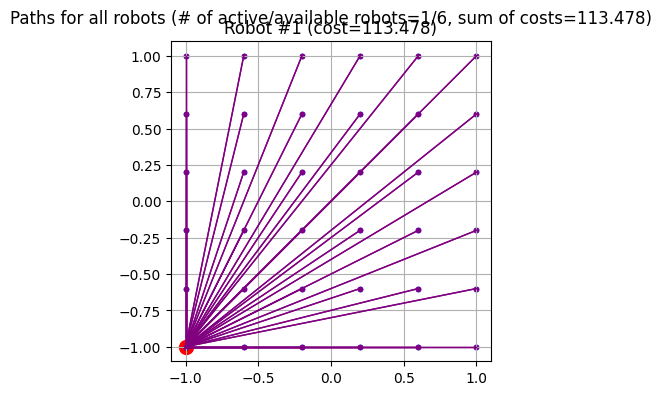

Found heuristic solution: objective 113.4784011
Found a new solution with lower cost(58.420)!


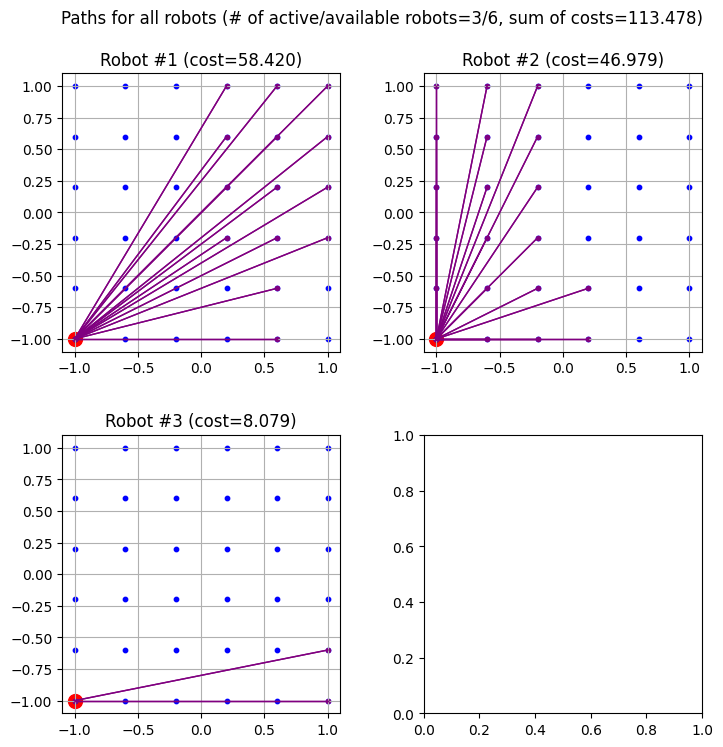

Found heuristic solution: objective 58.4197381
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...
Concurrent spin time: 0.01s

Solved with dual simplex

Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 2.398915e+00, 5049 iterations, 0.13 seconds (0.24 work units)
Total elapsed time = 5.16s

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    2.39892    0  248   58.41974    2.39892  95.9%     -    5s
Found a new solution with lower cost(18.943)!


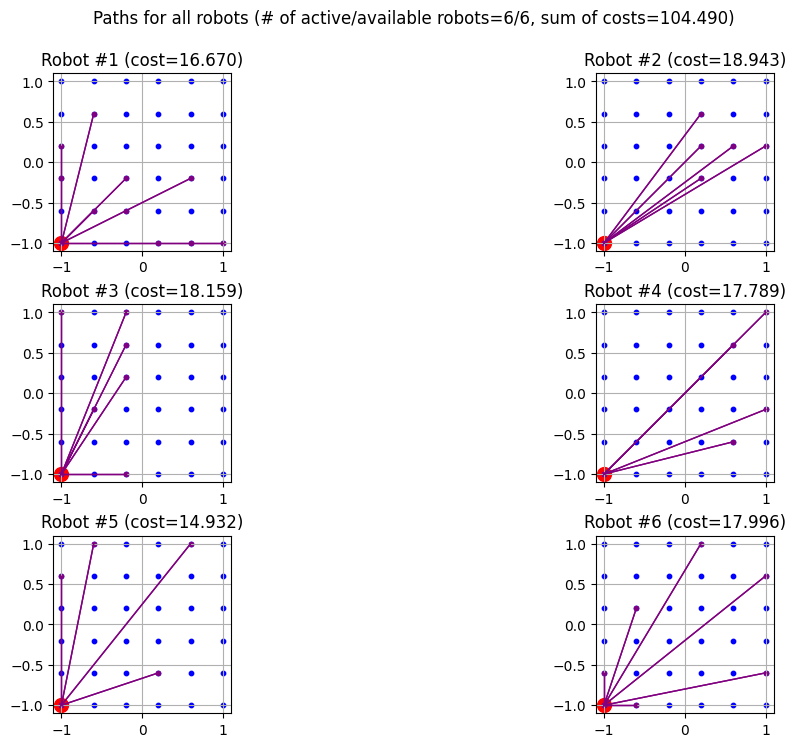

H    0     0                      18.9433151    2.39892  87.3%     -    7s
     0     0    2.39892    0  406   18.94332    2.39892  87.3%     -   10s
Found a new solution with lower cost(14.490)!


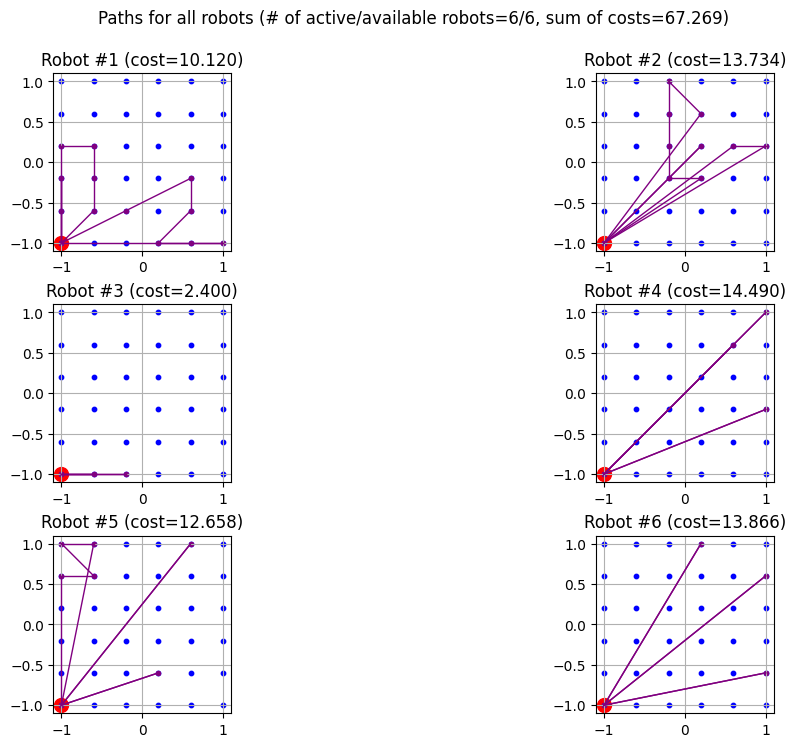

H    0     0                      14.4904695    2.39892  83.4%     -   15s
Found a new solution with lower cost(9.394)!


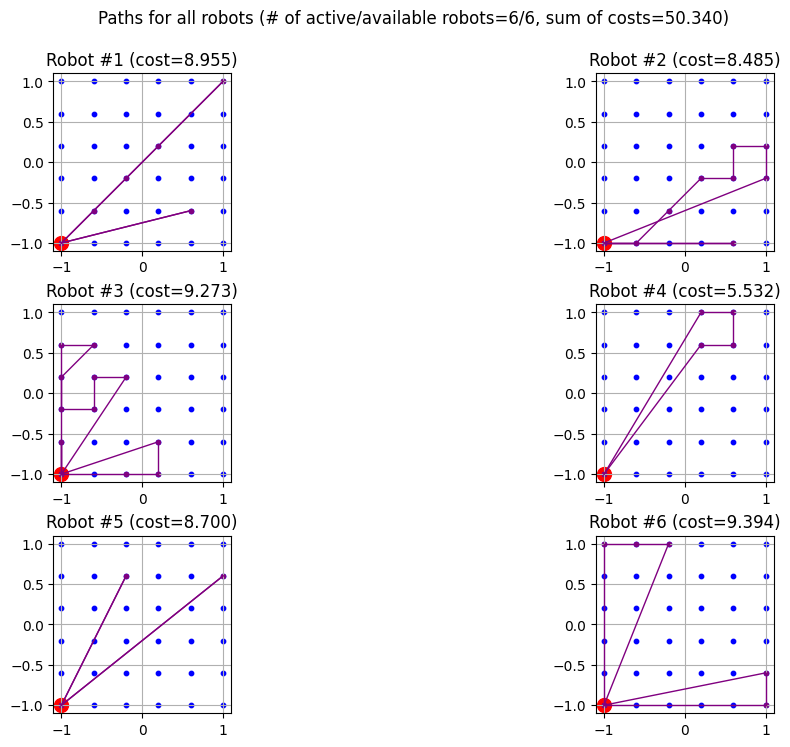

H    0     0                       9.3936737    2.39892  74.5%     -   17s
     0     0    2.39892    0  395    9.39367    2.39892  74.5%     -   17s
     0     0    2.39892    0  269    9.39367    2.39892  74.5%     -   22s
Found a new solution with lower cost(9.196)!


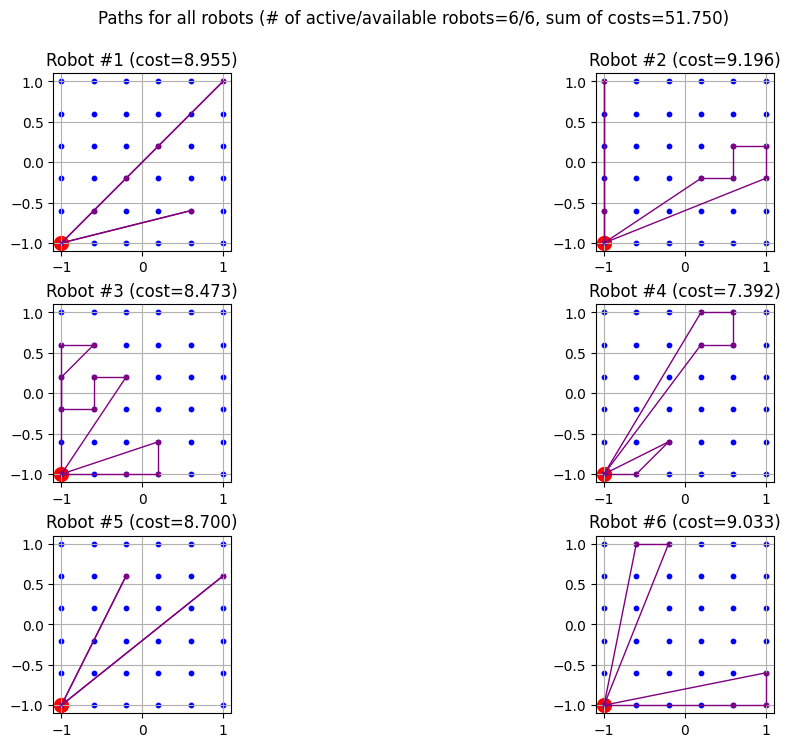

H    0     0                       9.1962864    2.39892  73.9%     -   24s
     0     0    2.39892    0  280    9.19629    2.39892  73.9%     -   25s
Found a new solution with lower cost(8.955)!


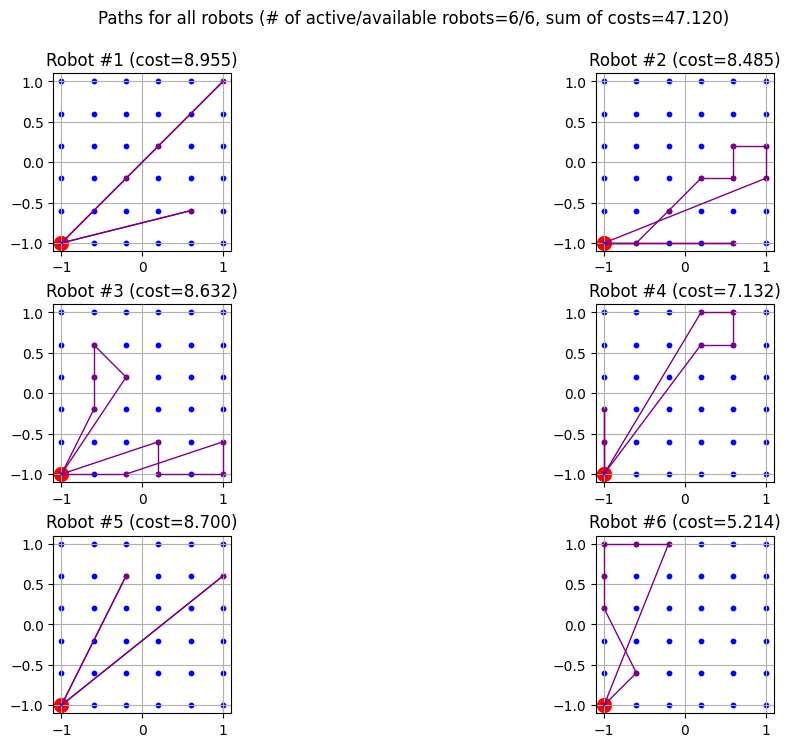

H    0     0                       8.9553387    2.39892  73.2%     -   32s
     0     0    2.39892    0  285    8.95534    2.39892  73.2%     -   33s
Found a new solution with lower cost(5.657)!
!This is guaranteed to be the optimal solution!


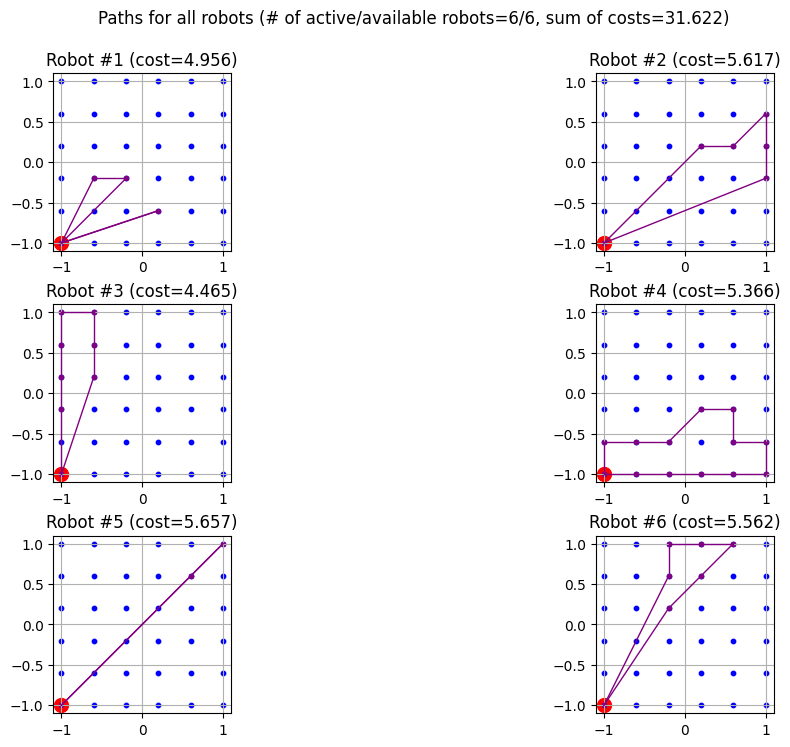

H    0     0                       5.6568542    2.39892  57.6%     -   35s
     0     0    2.39892    0  363    5.65685    2.39892  57.6%     -   35s

Cutting planes:
  Implied bound: 8
  MIR: 47
  StrongCG: 5
  Flow cover: 18
  RLT: 15
  Relax-and-lift: 15

Explored 1 nodes (133955 simplex iterations) in 35.84 seconds (109.57 work units)
Thread count was 14 (of 14 available processors)

Solution count 8: 5.65685 8.95534 9.19629 ... 113.478

Solve interrupted
Best objective 5.656854249492e+00, best bound 2.398915210301e+00, gap 57.5928%

User-callback calls 6798, time in user-callback 5.72 sec


In [11]:
m._x = x
solver = MILPSolver(m)
solver.solve()

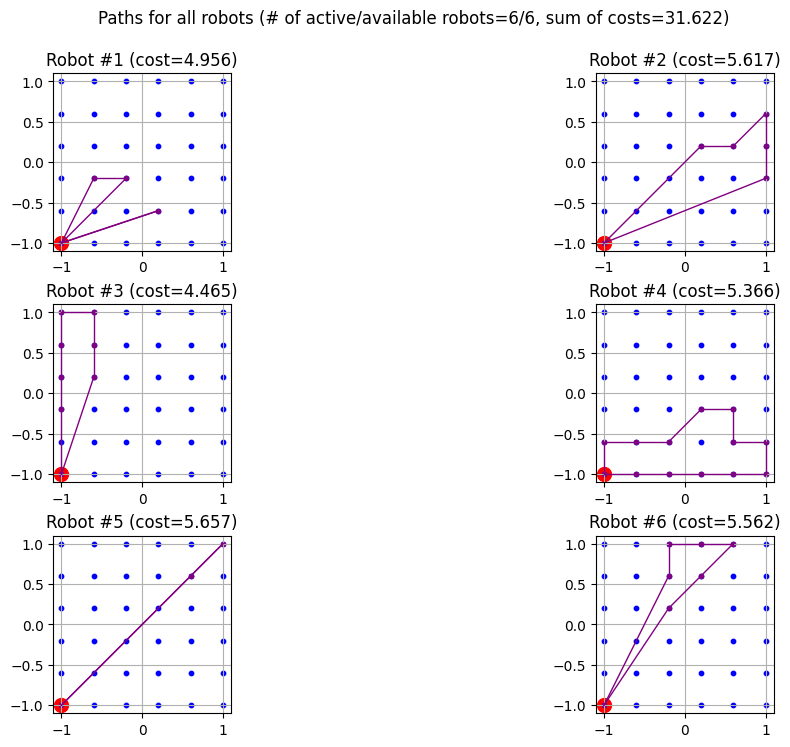

In [12]:
visualize_paths_brute_force(MILPSolver.min_cost_edges)
# visualize_paths_faster(MILPSolver.min_cost_edges)